In [110]:
import pandas as pd
import geopandas as gpd

In [46]:
%matplotlib inline

In [47]:
aux_base_dir = '/Volumes/TOSHIBA/datasets/'
#df_midias = pd.read_excel('{}/Midias Três Meios_Brasil.xlsx'.format(aux_base_dir), header=1)


In [301]:
df_midias = pd.read_excel('~/Downloads/moohve/data/Midias Geofusion - 22072020 (1).xlsx', header=1)

In [302]:
df_midias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98900 entries, 0 to 98899
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Código             98900 non-null  object 
 1   Nome               98039 non-null  object 
 2   Endereço           98900 non-null  object 
 3   Compl              57302 non-null  object 
 4   Bairro             78073 non-null  object 
 5   CEP                10046 non-null  object 
 6   Município          98900 non-null  object 
 7   Estado             98900 non-null  object 
 8   DDD                90 non-null     float64
 9   Telefone           90 non-null     object 
 10  Situação           73975 non-null  object 
 11  Tipo               85852 non-null  object 
 12  Nota               2112 non-null   object 
 13  Roteiro            4089 non-null   object 
 14  Exibidor           35653 non-null  object 
 15  Segmento           125 non-null    object 
 16  Formato            841

## Limpeza de dados da tabela

GOAL: enriquecer / limpar os dados da tabeala de mídias

* O objetivo do tratamento dessa base de mídia de propriedades out of home é trazer registros únicos de pontos de mídia com informações mais completas possíveis.

* Para identificar se existe duplicação de informação, devemos partir da informação de latitude/longitude, que devem ser únicas, exceto em casos de outdoor duplo ou triplo.

* (A) Para os casos em que não existe um Lat/Long na linha, devemos enriquecer a base com base no endereço descrito.

* O objetivo é trazer a maior quantidade de informações possíveis sobre cada ponto.

Se houver pontos repetidos, ou seja, mais de um cadastro em um único ponto é necessário analisar: trata-se de meios/veículos/propriedades diferentes? Se a resposta for sim, é necessário manter os dois registros. Caso contrário, manter o registro mais completo e complementar informações faltantes quando possível (ou seja, se alguma outra linha do arquivo tiver a informação faltante).

A regra de manter a informação mais completa e complementar as faltantes se houver no arquivo é válido para cada linha de lat/long.

Ex: Os códigos:

VSK0005

VSK0119

É um único relógio de rua com descrições diferentes:

https://www.google.com.br/maps/@-12.8945078,-38.4831985,3a,75y,104.71h,77.43t/data=!3m7!1e1!3m5!1sVSYrGgVCd-2OS72vgxU1Hg!2e0!6s%2F%2Fgeo1.ggpht.com%2Fcbk%3Fpanoid%3DVSYrGgVCd-2OS72vgxU1Hg%26output%3Dthumbnail%26cb_client%3Dmaps_sv.tactile.gps%26thumb%3D2%26w%3D203%26h%3D100%26yaw%3D202.7826%26pitch%3D0%26thumbfov%3D100!7i13312!8i6656

O mesmo acontece para os códigos:

OUTSOC02582

OUTSOC02869

OUTSOC02609

OUTSOC02526

OUTSOC02747

Mas as informações em cada linha são idênticas.

Ou

MO0078

MO0146

MO0240

 

Este outro caso merece atenção:

NOV001

929799

KRO5917

BROT01

Existe linha sem o exibidor e linha sem o complemento. O output, entretanto, deve ser o máximo de variáveis possíveis, ou seja, além daquelas que se repetem entre as linhas também buscar o exibidor e o complemento presente em parte delas.

 Mariana!

Conforme nosso conf call de hoje, seguem abaixo nossas sugestões. Aguardamos seu de acordo e orientações para realizarmos o tratamento da base.

1. Registros sem Lat/Long: 662
--> (B) podemos gerar Lat/Long a partir dos endereços cadastrados

2. Lat/Long fora do território nacional - falta do sinal negativo
--> (C) podemos acertar esses registros

3. Lat/Long fora do território nacional - aparente troca de lat x long
--> (D) podemos filtrar as longitudes maiores do que -34 e fazer a troca, porém alguns continuarão posicionando fora do território nacional. Iremos marcar os registros que sofreram essa alteração para posterior tratamento por vocês.

4. Campos "Nome" vazio + "Exibidor" completo: 206 casos
--> (E) podemos popular os registros de "Nome" vazio com o dado do campo "Exibidor"

5. Registros únicos: dos 91.400 registros, 65.583 são únicos. O restante demanda tratamento.
--> Mariana precisa informar quais campos devem ser considerados para definir que um registro não está duplicado (meios/veículos/propriedades não são campos da base de dados). 
    (F) Nome
        Município
        Estado
        Tipo
        Tipo de Mídia
        Longitude
        Latitude 


Por favor, tem como marcar na base cada um dos processos que foi realizado para cada uma das linhas? Pensei em uma coluna para cada ação, apenas com a indicação se esse item (1, 2, 3, 4 ou 5) foi realizado.

Os campos são:
Obrigado e abs,
      Por fim, gostaria de pedir que ao final fosse criada mais uma coluna com a recomendação manter ou excluir (com base nos itens discutidos anteriormente), sem que as informações fosse apagada. O que acham?


In [303]:
df_midias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98900 entries, 0 to 98899
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Código             98900 non-null  object 
 1   Nome               98039 non-null  object 
 2   Endereço           98900 non-null  object 
 3   Compl              57302 non-null  object 
 4   Bairro             78073 non-null  object 
 5   CEP                10046 non-null  object 
 6   Município          98900 non-null  object 
 7   Estado             98900 non-null  object 
 8   DDD                90 non-null     float64
 9   Telefone           90 non-null     object 
 10  Situação           73975 non-null  object 
 11  Tipo               85852 non-null  object 
 12  Nota               2112 non-null   object 
 13  Roteiro            4089 non-null   object 
 14  Exibidor           35653 non-null  object 
 15  Segmento           125 non-null    object 
 16  Formato            841

In [304]:
print('Quantidade de linhas na tabela original => {}'.format(len(df_midias)))

Quantidade de linhas na tabela original => 98900


In [305]:
df_midias.columns

Index(['Código', 'Nome', 'Endereço', 'Compl', 'Bairro', 'CEP', 'Município',
       'Estado', 'DDD', 'Telefone', 'Situação', 'Tipo', 'Nota', 'Roteiro',
       'Exibidor', 'Segmento', 'Formato', 'Fluxo Estimado', 'Tipo de Mídia',
       'Longitude', 'Latitude', 'Microárea', 'Microrregião', 'Mesorregião',
       'Região Geográfica'],
      dtype='object')

## entradas sem informação de LatLong

In [306]:
df_midias = df_midias.assign(**{'CHK_LATLONG_VALID':~((df_midias['Latitude'].isna()) | (df_midias['Longitude'].isna()))})
df_midias.groupby('CHK_LATLONG_VALID').count()[['Código']]

,Código
CHK_LATLONG_VALID,
False,2802
True,96098


In [307]:
df_midias[~df_midias['CHK_LATLONG_VALID']][['Código', 'Latitude', 'Longitude', 'Município', 'Bairro', 'Endereço', 'Compl']]


,Código,Latitude,Longitude,Município,Bairro,Endereço,Compl
208,ACES56,NaN,NaN,Contagem,NaN,Rua Renato Azeredo,NaN
228,SIN0255,NaN,NaN,Florianópolis,NaN,Rua São Cristovão Trevo Inss- Continente Senti...,NaN
290,INO0416,NaN,NaN,Niterói,São Francisco,Av. Presidente Rossevelt 49,"Av. Presidente Rossevelt, 49"
465,PLU0167,NaN,NaN,Rio de Janeiro,NaN,Avenida Coelho da Rocha 1426,NaN
567,UBH0300,NaN,NaN,Belo Horizonte,NaN,Av. Dom Pedro I 585,sem complemento
...,...,...,...,...,...,...,...
97591,FACULT4321,NaN,NaN,Guaçuí,Tancredo Neves,Av. José Moraes Moulin,NaN
97593,FACULT4507,NaN,NaN,Porto Velho,Cascalheira,Av. Mam 1520,NaN
97595,FACULT6109,NaN,NaN,Santana do Livramento,Fortim,Av. Paul Harris 410,NaN
97596,FACULT1457,NaN,NaN,Salto,Centro,Pca. Antônio Vieira Tavares 73,NaN


In [308]:
### homogeiniza os dados de municipio e endereco (para tirar acentos)

In [309]:
municipios = list(df_midias['Município'].unique())

In [310]:
# !pip install unidecode 
import unidecode

In [311]:
m2 = []
for m in municipios:
    m2.append(unidecode.unidecode(m))

In [312]:
df_midias['municipio_1'] = df_midias['Município'].apply(lambda x: unidecode.unidecode(x))
df_midias['endereco_1'] = df_midias['Endereço'].apply(lambda x: unidecode.unidecode(x))

In [313]:
df_midias[~df_midias['CHK_LATLONG_VALID']][['Código', 'Latitude', 'Longitude', 'municipio_1', 'endereco_1', 'Município', 'Bairro', 'Endereço', 'Compl']]

,Código,Latitude,Longitude,municipio_1,endereco_1,Município,Bairro,Endereço,Compl
208,ACES56,NaN,NaN,Contagem,Rua Renato Azeredo,Contagem,NaN,Rua Renato Azeredo,NaN
228,SIN0255,NaN,NaN,Florianopolis,Rua Sao Cristovao Trevo Inss- Continente Senti...,Florianópolis,NaN,Rua São Cristovão Trevo Inss- Continente Senti...,NaN
290,INO0416,NaN,NaN,Niteroi,Av. Presidente Rossevelt 49,Niterói,São Francisco,Av. Presidente Rossevelt 49,"Av. Presidente Rossevelt, 49"
465,PLU0167,NaN,NaN,Rio de Janeiro,Avenida Coelho da Rocha 1426,Rio de Janeiro,NaN,Avenida Coelho da Rocha 1426,NaN
567,UBH0300,NaN,NaN,Belo Horizonte,Av. Dom Pedro I 585,Belo Horizonte,NaN,Av. Dom Pedro I 585,sem complemento
...,...,...,...,...,...,...,...,...,...
97591,FACULT4321,NaN,NaN,Guacui,Av. Jose Moraes Moulin,Guaçuí,Tancredo Neves,Av. José Moraes Moulin,NaN
97593,FACULT4507,NaN,NaN,Porto Velho,Av. Mam 1520,Porto Velho,Cascalheira,Av. Mam 1520,NaN
97595,FACULT6109,NaN,NaN,Santana do Livramento,Av. Paul Harris 410,Santana do Livramento,Fortim,Av. Paul Harris 410,NaN
97596,FACULT1457,NaN,NaN,Salto,Pca. Antonio Vieira Tavares 73,Salto,Centro,Pca. Antônio Vieira Tavares 73,NaN


### endereços com apenas a referencia da Cidade

In [314]:
df_midias = df_midias.assign(**{'CHK_APENAS_CIDADE':(df_midias['municipio_1'] == df_midias['endereco_1'])})
df_midias.groupby('CHK_APENAS_CIDADE').count()[['Código']]
#df_midias[
#    ((df_midias['Latitude'].isna()) | (df_midias['Longitude'].isna())) & (df_midias['municipio_1'] == df_midias['endereco_1'])][['Código', 'Latitude', 'Longitude', 'municipio_1', 'endereco_1', 'Município', 'Bairro', 'Endereço', 'Compl', 'Estado']]

,Código
CHK_APENAS_CIDADE,
False,98884
True,16


### registros que tem endereço + cidade + estado mas nao tem lat long

In [315]:
#df_midias[
#    ((df_midias['Latitude'].isna()) | (df_midias['Longitude'].isna())) & (df_midias['municipio_1'] != df_midias['endereco_1'])][['Código', 'Latitude', 'Longitude', 'municipio_1', 'endereco_1', 'Município', 'Bairro', 'Endereço', 'Compl', 'Estado']]


### distribuicao por estado dos endereços que nao tem lat long

In [316]:
df_midias[
    (~df_midias['CHK_LATLONG_VALID']) & (~df_midias['CHK_APENAS_CIDADE'])][['Código', 'Latitude', 'Longitude', 'municipio_1', 'endereco_1', 'Município', 'Bairro', 'Endereço', 'Compl', 'Estado']].groupby('Estado').count()


,Código,Latitude,Longitude,municipio_1,endereco_1,Município,Bairro,Endereço,Compl
Estado,,,,,,,,,
AC,25,0,0,25,25,25,19,25,8
AL,33,0,0,33,33,33,32,33,5
AM,50,0,0,50,50,50,47,50,5
AP,16,0,0,16,16,16,14,16,2
BA,228,0,0,228,228,228,143,228,50
CE,81,0,0,81,81,81,67,81,14
DF,132,0,0,132,132,132,92,132,58
ES,70,0,0,70,70,70,67,70,8
GO,98,0,0,98,98,98,75,98,25


### registros que não tem denominacao de bairro (Diversos)

In [317]:
df_midias = df_midias.assign(**{'CHK_BAIRRO_INVALIDO':df_midias['Bairro'] == 'Diversos'})
df_midias.groupby('CHK_BAIRRO_INVALIDO').count()
#df_midias[
#    ((df_midias['Latitude'].isna()) | (df_midias['Longitude'].isna())) & (df_midias['Bairro'] == 'Diversos') & (df_midias['municipio_1'] != df_midias['endereco_1'])][['Código', 'Latitude', 'Longitude', 'municipio_1', 'endereco_1', 'Município', 'Bairro', 'Endereço', 'Compl']]


,Código,Nome,Endereço,Compl,Bairro,CEP,Município,Estado,DDD,Telefone,...,Longitude,Latitude,Microárea,Microrregião,Mesorregião,Região Geográfica,CHK_LATLONG_VALID,municipio_1,endereco_1,CHK_APENAS_CIDADE
CHK_BAIRRO_INVALIDO,,,,,,,,,,,,,,,,,,,,,
False,98893,98032,98893,57295,78066,10039,98893,98893,90,90,...,96093,96093,84192,98893,98893,98893,98893,98893,98893,98893
True,7,7,7,7,7,7,7,7,0,0,...,5,5,5,7,7,7,7,7,7,7


### endereços que o # está errado (ZERO)

In [318]:
df_midias = df_midias.assign(**{'CHK_ENDERECO_COM_ZERO':(df_midias['endereco_1'].str[-2:] == ' 0')})
#df_midias[
#    ((df_midias['Latitude'].isna()) | (df_midias['Longitude'].isna())) & 
#    (df_midias['Bairro'] != 'Diversos') & 
#    (df_midias['endereco_1'].str[-2:] == ' 0') & 
#    (df_midias['municipio_1'] != df_midias['endereco_1'])][['Código', 'Latitude', 'Longitude', 'municipio_1', 'endereco_1', 'Município', 'Bairro', 'Endereço', 'Compl']]
df_midias.groupby('CHK_ENDERECO_COM_ZERO').count()
# df_midias[df_midias['CHK_ENDERECO_COM_ZERO']]

,Código,Nome,Endereço,Compl,Bairro,CEP,Município,Estado,DDD,Telefone,...,Latitude,Microárea,Microrregião,Mesorregião,Região Geográfica,CHK_LATLONG_VALID,municipio_1,endereco_1,CHK_APENAS_CIDADE,CHK_BAIRRO_INVALIDO
CHK_ENDERECO_COM_ZERO,,,,,,,,,,,,,,,,,,,,,
False,97949,97088,97949,56480,77179,9696,97949,97949,90,90,...,95158,83302,97949,97949,97949,97949,97949,97949,97949,97949
True,951,951,951,822,894,350,951,951,0,0,...,940,895,951,951,951,951,951,951,951,951


### endereços que tem apenas "Pca"

In [319]:
df_midias = df_midias.assign(**{'CHK_APENAS_PCA':(df_midias['endereco_1'] == 'Pca')})
#df_midias[
#    ((df_midias['Latitude'].isna()) | (df_midias['Longitude'].isna())) & 
#    (df_midias['Bairro'] != 'Diversos') & 
#    (df_midias['endereco_1'] == 'Pca') & 
##    (df_midias['endereco_1'].str.contains('Pca')) & 
#    (df_midias['municipio_1'] != df_midias['endereco_1'])][['Código', 'Latitude', 'Longitude', 'municipio_1', 'endereco_1', 'Município', 'Bairro', 'Endereço', 'Compl']]
df_midias.groupby('CHK_APENAS_PCA').count()

,Código,Nome,Endereço,Compl,Bairro,CEP,Município,Estado,DDD,Telefone,...,Microárea,Microrregião,Mesorregião,Região Geográfica,CHK_LATLONG_VALID,municipio_1,endereco_1,CHK_APENAS_CIDADE,CHK_BAIRRO_INVALIDO,CHK_ENDERECO_COM_ZERO
CHK_APENAS_PCA,,,,,,,,,,,,,,,,,,,,,
False,98873,98012,98873,57301,78072,10045,98873,98873,90,90,...,84196,98873,98873,98873,98873,98873,98873,98873,98873,98873
True,27,27,27,1,1,1,27,27,0,0,...,1,27,27,27,27,27,27,27,27,27


### endereços unicos que potencialmente sao validos

In [320]:
e = list(df_midias[
    ((df_midias['Latitude'].isna()) | (df_midias['Longitude'].isna())) & 
    (df_midias['Bairro'] != 'Diversos') & 
    (df_midias['municipio_1'] != df_midias['endereco_1'])][['Código', 'Latitude', 'Longitude', 'municipio_1', 'endereco_1', 'Município', 'Bairro', 'Endereço', 'Compl']]['endereco_1'].unique())
e.sort()
len(e)


2455

In [321]:
import re
pattern1 = re.compile('(.+)(\s+)(\d+)$')
def is_minimally_valid_address(addr):
    v = pattern1.match(addr)
    if v:
        parts = pattern1.findall(addr)
        if parts[0][2] == '0':
            return None
    return v
    
    

In [322]:
# is_minimally_valid_address('Balsamo 10')
df_midias.columns

Index(['Código', 'Nome', 'Endereço', 'Compl', 'Bairro', 'CEP', 'Município',
       'Estado', 'DDD', 'Telefone', 'Situação', 'Tipo', 'Nota', 'Roteiro',
       'Exibidor', 'Segmento', 'Formato', 'Fluxo Estimado', 'Tipo de Mídia',
       'Longitude', 'Latitude', 'Microárea', 'Microrregião', 'Mesorregião',
       'Região Geográfica', 'CHK_LATLONG_VALID', 'municipio_1', 'endereco_1',
       'CHK_APENAS_CIDADE', 'CHK_BAIRRO_INVALIDO', 'CHK_ENDERECO_COM_ZERO',
       'CHK_APENAS_PCA'],
      dtype='object')

In [323]:
df_midias = df_midias.assign(**{'CHK_ADDRESS_STRUCTURE_OK':df_midias.apply(lambda x: is_minimally_valid_address(x['endereco_1']), axis=1)})
df_midias = df_midias.assign(**{'CHK_FIND_LATLONG':(~df_midias['CHK_LATLONG_VALID'] & ~df_midias['CHK_APENAS_CIDADE'] & ~df_midias['CHK_BAIRRO_INVALIDO'] & ~df_midias['CHK_ENDERECO_COM_ZERO'] & ~df_midias['CHK_APENAS_PCA'] & df_midias['CHK_ADDRESS_STRUCTURE_OK'])})
#val = df_midias[
#    ((df_midias['Latitude'].isna()) | (df_midias['Longitude'].isna())) & 
#    (df_midias['Bairro'] != 'Diversos') & 
#    (df_midias['municipio_1'] != df_midias['endereco_1'])].apply(lambda x: is_minimally_valid_address(x['endereco_1']), axis=1)

df_midias.groupby('CHK_FIND_LATLONG').count()

,Código,Nome,Endereço,Compl,Bairro,CEP,Município,Estado,DDD,Telefone,...,Mesorregião,Região Geográfica,CHK_LATLONG_VALID,municipio_1,endereco_1,CHK_APENAS_CIDADE,CHK_BAIRRO_INVALIDO,CHK_ENDERECO_COM_ZERO,CHK_APENAS_PCA,CHK_ADDRESS_STRUCTURE_OK
CHK_FIND_LATLONG,,,,,,,,,,,,,,,,,,,,,
False,96982,96121,96982,56773,76627,10018,96982,96982,87,87,...,96982,96982,96982,96982,96982,96982,96982,96982,96982,50883
True,1918,1918,1918,529,1446,28,1918,1918,3,3,...,1918,1918,1918,1918,1918,1918,1918,1918,1918,1918


In [324]:
# df_midias['find_latlong'] = df_midias.apply(lambda x: is_minimally_valid_address(x['endereco_1']), axis=1)

### salva os endereços que precisam ter a lat long encontrada

In [325]:
df_midias[df_midias['CHK_FIND_LATLONG']].to_csv('./data/find_latlong.csv')

### verifica se as lat longs existentes estao dentro dos estados correspondentes 

In [326]:
estados_br = gpd.read_file('/Volumes/TOSHIBA/datasets/mapas/Estados_do_Brasil/Brasil.shp')

In [328]:
#def checkPt(lat,lon,poly):
#    pt = Point(lat,lon)
#    return pt.within(poly)
#    
#pts = pd.merge(df_midias, estados_br, left_on='Estado', right_on='UF')
#
#pts = pts.assign(**{'CHK_LATLONG_NO_ESTADO':pts.apply(lambda x: checkPt(x['lon2'], x['lat2'], x['geometry']), axis=1)})
#pts


In [329]:
#uf = estados_br.values[0]
#uf
#pts = gpd.GeoDataFrame(geometry=df_midias[['lat2', 'lon2']].apply(lambda x:Point(x['lon2'], x['lat2']), axis=1))




In [335]:
df_midias.columns

Index(['Código', 'Nome', 'Endereço', 'Compl', 'Bairro', 'CEP', 'Município',
       'Estado', 'DDD', 'Telefone', 'Situação', 'Tipo', 'Nota', 'Roteiro',
       'Exibidor', 'Segmento', 'Formato', 'Fluxo Estimado', 'Tipo de Mídia',
       'Longitude', 'Latitude', 'Microárea', 'Microrregião', 'Mesorregião',
       'Região Geográfica', 'CHK_LATLONG_VALID', 'municipio_1', 'endereco_1',
       'CHK_APENAS_CIDADE', 'CHK_BAIRRO_INVALIDO', 'CHK_ENDERECO_COM_ZERO',
       'CHK_APENAS_PCA', 'CHK_ADDRESS_STRUCTURE_OK', 'CHK_FIND_LATLONG',
       'ESTADOS', 'REGIAO', 'COD_UF', 'UF', 'geometry'],
      dtype='object')

In [330]:
df_midias = pd.merge(df_midias, estados_br, left_on='Estado', right_on='UF')

In [331]:
#df_midias = df_midias.drop(columns=['lat2_y', 'lon2_y', 'CHK_LATLONG_VALID_UF', 'pt']).rename(columns={'lat2_x':'lat2', 'lon2_x':'lon2'})

In [332]:
#munics

In [340]:
municsdf = pd.DataFrame()
values = []
for key,value in estados_br.iterrows():
    items = df_midias[(df_midias['Estado'] == value[3]) & (df_midias['CHK_LATLONG_VALID'])][['Latitude', 'Longitude', 'Código']]
    if len(items) > 0:         
        it2 = pd.DataFrame(items)
        datax = items.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
        print('STATE {} has records = {}'.format(value[3], len(datax)))
        munics = it2.assign(**{'pt':datax})
        geodf = gpd.GeoDataFrame(geometry=munics['pt'])
        munics['CHK_LATLONG_VALID_UF'] = geodf.within(value[4])
        values.append(munics)
municsdf = pd.concat(values)
df_midiasx = pd.merge(df_midias, municsdf[['Código', 'CHK_LATLONG_VALID_UF']].rename(columns={'Código':'COD_MUNIC'}), left_on='Código', right_on='COD_MUNIC')
df_midiasx    
    

STATE AC has records = 125
STATE AL has records = 582
STATE AP has records = 270
STATE AM has records = 918
STATE BA has records = 6104
STATE CE has records = 3040
STATE DF has records = 2132
STATE ES has records = 1015
STATE GO has records = 1786
STATE MA has records = 1286
STATE MT has records = 1327
STATE MS has records = 2339
STATE MG has records = 8796


KeyboardInterrupt: 

In [280]:
geodf = gpd.GeoDataFrame(geometry=munics['pt'])
geodf.within(value[4])

array([ True])

In [192]:
df_midias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98900 entries, 0 to 98899
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Código                    98900 non-null  object 
 1   Nome                      98039 non-null  object 
 2   Endereço                  98900 non-null  object 
 3   Compl                     57302 non-null  object 
 4   Bairro                    78073 non-null  object 
 5   CEP                       10046 non-null  object 
 6   Município                 98900 non-null  object 
 7   Estado                    98900 non-null  object 
 8   DDD                       90 non-null     float64
 9   Telefone                  90 non-null     object 
 10  Situação                  73975 non-null  object 
 11  Tipo                      85852 non-null  object 
 12  Nota                      2112 non-null   object 
 13  Roteiro                   4089 non-null   object 
 14  Exibid

#### Analise - 662 sem LatLong ... 
1. nao tratáveis de forma escalável
    * 4x linhas que provavelmente sao endereços  de entrada na cidade -> endereco = nome_cidade 
    * 2x bairros "Diversos" 
    * 5x endereços com referencias muito amplas ... # 0 no final do endereço 
    * 26x endereços apenas com referencias de 'Pça' na cidade ... ex: Pça em SP, Salvador, Curitiba
    * xx  com endereço sem # 
2. trataveis -> 435 (conversiveis para LatLong)

=> coluna "find_latlong" tem o flag se ele pode ser convertido ou nao ... 

### verifica as lat longs informadas e verifica se elas sao validas

NOTA: ela transforma as lat longs que forem maiorse que 90o ... foram identificadas lat longs que estavam com o "ponto" de separacao de decimais, minutos e segundos errada ... entao verificar se uma aproximacao (divindo o valor encontrado por 10) funciona

In [91]:

# https://www.mapsofworld.com/lat_long/brazil-lat-long.html
ref = [(-90, -90)]
def div10(v, m):
    while ((m < 0) & (v < m)) | ((m > 0) & (v > m)):
        v = v / 10
    return v

# fix decimal places (data exported with several distinct parameters)

df_midias['lat2'] = df_midias['Latitude'].apply(lambda x: div10(x, ref[0][0]))
df_midias['lon2'] = df_midias['Longitude'].apply(lambda x: div10(x, ref[0][1]))
df_set01 = df_midias.dropna(subset=['lat2','lon2'])
df_set01[['lat2','lon2']]


,lat2,lon2
0,-23.583256,-48.037645
1,-23.559400,-46.637700
2,-20.308385,-40.296230
3,-23.578925,-46.675781
4,-19.908594,-43.927834
...,...,...
98895,-9.652024,-35.733261
98896,-15.400721,-38.997977
98897,-12.968886,-38.433325
98898,-14.308407,-39.322806


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120ff8f60>,
      dtype=object)

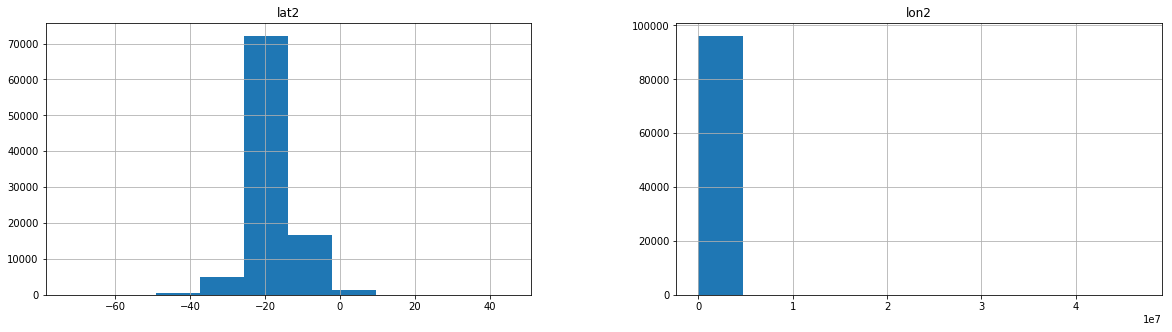

In [92]:
df_set01[['lat2', 'lon2']].hist(figsize=(20,5))

### valores muito grandes (fora do Brasil) 

se a lat long estiver positiva muito grande, entao a referencia está errada

In [94]:
# caso 1 - valores muito grandes que tem o sinal invertido da longitude 
nv = df_set01[df_set01['lon2'] > 1000]['lon2'].div(1000000)
nv

2598     46.761235
38259    46.761235
Name: lon2, dtype: float64

In [95]:
for row in nv.index:
    df_set01.loc[row, 'lon2'] = nv[row]


/Users/alexjunq/.virtualenvs/konker/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [96]:
# caso 2 - valores entre 100 e 1000
nv2 = df_set01[df_set01['lon2'] > 100]['lon2'].div(10)
nv2
for row in nv2.index:
    df_set01.loc[row, 'lon2'] = nv2[row]
df_set01[['lat2', 'lon2']]
# identificar quem esta com a LAT LONG invertida
range_long = [-73, -34]
range_lat = [-33, 5]

nv = df_set01[(df_set01['lat2'] >= range_long[0]) & (df_set01['lat2'] <= range_long[1])]

In [98]:
for row in nv.index:
    lat_aux = df_set01.loc[row, 'lat2']
    lon_aux = df_set01.loc[row, 'lon2']
    # print(lat_aux, lon_aux)
    df_set01.loc[row, 'lat2'] = lon_aux
    df_set01.loc[row, 'lon2'] = lat_aux

In [99]:
# agora estamos com os dados com lat long mais correto

In [100]:
df_midias

,Código,Nome,Endereço,Compl,Bairro,CEP,Município,Estado,DDD,Telefone,...,Latitude,Microárea,Microrregião,Mesorregião,Região Geográfica,municipio_1,endereco_1,find_latlong,lat2,lon2
0,KRO7913,Midia Paineis,Sem Nome,RUA PE ALBUQUERQUE - CASI - REST COMA BEM,NaN,NaN,Itapetininga,SP,NaN,NaN,...,-23.583256,NaN,Itapetininga,Itapetininga,Sudeste,Itapetininga,Sem Nome,None,-23.583256,-48.037645
1,JCD3406,Jc Decaux,Av. da Liberdade,"Liberdade / Rua Condessa de Sao Joaquim, Cc",Liberdade/São Joaquim,NaN,São Paulo,SP,NaN,NaN,...,-23.559400,Liberdade,São Paulo,Metropolitana de São Paulo,Sudeste,Sao Paulo,Av. da Liberdade,None,-23.559400,-46.637700
2,MAE0227,Maelly,Do Marquinho (Boulevard) 346,Em frente ao Boulevard,Santa Lúcia,NaN,Vitória,ES,NaN,NaN,...,-20.308385,Praia do Canto,Vitória,Central Espírito-santense,Sudeste,Vitoria,Do Marquinho (Boulevard) 346,"<re.Match object; span=(0, 28), match='Do Marq...",-20.308385,-40.296230
3,OTI0446,Ótima,Av. Nove de Julho 5229,NaN,Itaim Bibi,NaN,São Paulo,SP,NaN,NaN,...,-23.578925,Itaim Bibi,São Paulo,Metropolitana de São Paulo,Sudeste,Sao Paulo,Av. Nove de Julho 5229,"<re.Match object; span=(0, 22), match='Av. Nov...",-23.578925,-46.675781
4,JCD2839,Jc Decaux,Av. Silviano Brandao 827,"Av. Silviano Brandao, 827",Sagrada Família,NaN,Belo Horizonte,MG,NaN,NaN,...,-19.908594,Sagrada Família,Belo Horizonte,Metropolitana de Belo Horizonte,Sudeste,Belo Horizonte,Av. Silviano Brandao 827,"<re.Match object; span=(0, 24), match='Av. Sil...",-19.908594,-43.927834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98895,959587,BANDEIRANTES,Manoel Moreira e Silva,NaN,Farol,NaN,Maceió,AL,NaN,NaN,...,-9.652024,Farol,Maceió,Leste Alagoano,Nordeste,Maceio,Manoel Moreira e Silva,None,-9.652024,-35.733261
98896,959210,OUTPLAK,Av Canavieiras,NaN,NaN,NaN,Ilhéus,BA,NaN,NaN,...,-15.400721,NaN,Ilhéus-Itabuna,Sul Baiano,Nordeste,Ilheus,Av Canavieiras,None,-15.400721,-38.997977
98897,959804,PONTO OUTDOOR,Av Jorge Amado Emporio,NaN,NaN,NaN,Salvador,BA,NaN,NaN,...,-12.968886,Boca do Rio / Imbuí,Salvador,Metropolitana de Salvador,Nordeste,Salvador,Av Jorge Amado Emporio,None,-12.968886,-38.433325
98898,959209,OUTPLAK,Av Ubaitaba,NaN,NaN,NaN,Ilhéus,BA,NaN,NaN,...,-14.308407,NaN,Ilhéus-Itabuna,Sul Baiano,Nordeste,Ilheus,Av Ubaitaba,None,-14.308407,-39.322806


In [107]:
### as lat longs que estao no nordeste devem ter uma latitude entre 6oN e 25oS ... (9, -25) ... considernado que -25 é o sul da bahia

In [109]:
df_set01[(df_set01['Região Geográfica'] == 'Nordeste') &  (df_set01['lat2'] <= -10)]

,Código,Nome,Endereço,Compl,Bairro,CEP,Município,Estado,DDD,Telefone,...,Latitude,Microárea,Microrregião,Mesorregião,Região Geográfica,municipio_1,endereco_1,find_latlong,lat2,lon2
6,SKY0080,SKYFII,Saga - Ma02 São Luis,NaN,NaN,NaN,São Luís,MA,NaN,NaN,...,-25.078500,NaN,Aglomeração Urbana de São Luís,Norte Maranhense,Nordeste,Sao Luis,Saga - Ma02 Sao Luis,None,-25.078500,-44.283810
7,OUTSOC06397,OUTDOOR SOCIAL,Rua do Passo 108,NaN,NaN,NaN,Salvador,BA,NaN,NaN,...,-12.969200,Comércio / Pelourinho,Salvador,Metropolitana de Salvador,Nordeste,Salvador,Rua do Passo 108,"<re.Match object; span=(0, 16), match='Rua do ...",-12.969200,-38.507800
13,GREE1711,GIRLAN,Apos O Atacadao - Placa 2,APOS O ATACADAO - PLACA 02,NaN,NaN,Cruz das Almas,BA,NaN,NaN,...,-12.664789,NaN,Santo Antônio de Jesus,Metropolitana de Salvador,Nordeste,Cruz das Almas,Apos O Atacadao - Placa 2,"<re.Match object; span=(0, 25), match='Apos O ...",-12.664789,-39.114045
14,ARA0033,Aracajú outdoor,Av Beira Mar / Def. Parque dos Cajueiros / Vol...,NaN,Farolândia,NaN,Aracaju,SE,NaN,NaN,...,-10.960173,Farolândia,Aracaju,Leste Sergipano,Nordeste,Aracaju,Av Beira Mar / Def. Parque dos Cajueiros / Vol...,None,-10.960173,-37.054994
18,COM0235,Compasso,Av. Principal/Prox. Ao Shop. da Ilha,NaN,COHAMA,65074-115,São Luís,MA,NaN,NaN,...,-44.251992,NaN,Aglomeração Urbana de São Luís,Norte Maranhense,Nordeste,Sao Luis,Av. Principal/Prox. Ao Shop. da Ilha,None,-44.251992,-2.524681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98893,959805,PONTO OUTDOOR,C das Rvores Rua Prof Milton Ayres de Brito Jo...,NaN,Cabuçu,NaN,Salvador,BA,NaN,NaN,...,-23.438585,Continental,Salvador,Metropolitana de Salvador,Nordeste,Salvador,C das Rvores Rua Prof Milton Ayres de Brito Jo...,None,-23.438585,-46.558718
98896,959210,OUTPLAK,Av Canavieiras,NaN,NaN,NaN,Ilhéus,BA,NaN,NaN,...,-15.400721,NaN,Ilhéus-Itabuna,Sul Baiano,Nordeste,Ilheus,Av Canavieiras,None,-15.400721,-38.997977
98897,959804,PONTO OUTDOOR,Av Jorge Amado Emporio,NaN,NaN,NaN,Salvador,BA,NaN,NaN,...,-12.968886,Boca do Rio / Imbuí,Salvador,Metropolitana de Salvador,Nordeste,Salvador,Av Jorge Amado Emporio,None,-12.968886,-38.433325
98898,959209,OUTPLAK,Av Ubaitaba,NaN,NaN,NaN,Ilhéus,BA,NaN,NaN,...,-14.308407,NaN,Ilhéus-Itabuna,Sul Baiano,Nordeste,Ilheus,Av Ubaitaba,None,-14.308407,-39.322806


In [142]:
df_set01[(df_set01['Região Geográfica'] == 'Nordeste')][['Estado', 'Mesorregião', 'lat2_reference']].to_csv('~/Downloads/lat_por_estado.csv')


In [ ]:
dfx = df_set01[(df_set01['Região Geográfica'] == 'Nordeste') &
         (df_set01['lat2'] <= 0)].groupby(['Região Geográfica', 'Mesorregião', 'lat2_x']).count()['Código']
dfx.to_csv('~/Downloads/regioes.csv')
df_set01[(df_set01['Região Geográfica'] == 'Nordeste')]['Estado'].unique()
df_set01[['lat2','lon2','lat3', 'lon3']].describe()
df_set01[df_set01['Latitude2'] > 0]['Latitude2'].hist()
df_set01[demographics_points_2['Longitude2'] > 0]['Longitude2'].hist()
demographics_points_2[demographics_points_2['Longitude2']<180]['Longitude2'].hist()
demo3 = demographics_points_2[(demographics_points_2['Longitude2'] >= -74) &\
                      (demographics_points_2['Longitude2'] <= -20) &\
                      (demographics_points_2['Latitude2'] >= -33) &\
                      (demographics_points_2['Latitude2'] <= 5)]
                      
demo3.info()
demo2 = demographics_points_2[(demographics_points_2['Longitude2'] < -74) |\
                      (demographics_points_2['Longitude2'] > -20) |\
                      (demographics_points_2['Latitude2'] < -33) |\
                      (demographics_points_2['Latitude2'] > 5)]
                      

In [113]:
estados_br = gpd.read_file('/Volumes/TOSHIBA/datasets/mapas/Estados_do_Brasil/Brasil.shp')

In [116]:
estados_br

,ESTADOS,REGIAO,COD_UF,UF,geometry
0,Acre,Norte,12.0,AC,"POLYGON ((-73.80098 -7.11145, -73.74084 -7.143..."
1,Alagoas,Nordeste,27.0,AL,"MULTIPOLYGON (((-36.39119 -10.50082, -36.39864..."
2,Amapá,Norte,16.0,AP,"MULTIPOLYGON (((-51.37380 -0.37053, -51.37337 ..."
3,Amazonas,Norte,13.0,AM,"POLYGON ((-73.80098 -7.11145, -73.80106 -7.111..."
4,Bahia,Nordeste,29.0,BA,"MULTIPOLYGON (((-46.32975 -13.25248, -46.33072..."
5,Ceará,Nordeste,23.0,CE,"MULTIPOLYGON (((-41.40014 -3.32039, -41.39750 ..."
6,Distrito Federal,Centro Oeste,53.0,DF,"POLYGON ((-48.28667 -15.84282, -48.28464 -15.8..."
7,Espírito Santo,Sudeste,32.0,ES,"MULTIPOLYGON (((-40.22200 -17.98004, -39.83347..."
8,Goiás,Centro Oeste,52.0,GO,"POLYGON ((-53.25072 -17.61877, -53.24644 -17.6..."
9,Maranhão,Nordeste,21.0,MA,"MULTIPOLYGON (((-43.71565 -2.49527, -43.71523 ..."


In [119]:
pd.merge(df_set01[(df_set01['Região Geográfica'] == 'Nordeste')], estados_br, left_on='Estado', right_on='UF').apply(lambda x: , axis=1)



16514

In [134]:
from shapely.geometry import Point, Polygon

In [145]:
def checkPt(lat,lon,poly):
    pt = Point(lat,lon)
    return pt.within(poly)
    
pts = pd\
    .merge(df_set01[(df_set01['Região Geográfica'] == 'Nordeste')][['Latitude', 'Longitude', 'lat2', 'lon2', 'Estado']], estados_br, left_on='Estado', right_on='UF')

pts = pts.assign(**{'noestado':pts.apply(lambda x: checkPt(x['lon2'], x['lat2'], x['geometry']), axis=1)})
pts






,Latitude,Longitude,lat2,lon2,Estado,ESTADOS,REGIAO,COD_UF,UF,geometry,noestado
0,-25.078500,-44.283810,-25.078500,-44.283810,MA,Maranhão,Nordeste,21.0,MA,"MULTIPOLYGON (((-43.71565 -2.49527, -43.71523 ...",False
1,-44.251992,-2.524681,-44.251992,-2.524681,MA,Maranhão,Nordeste,21.0,MA,"MULTIPOLYGON (((-43.71565 -2.49527, -43.71523 ...",False
2,-2.541377,-44.262885,-2.541377,-44.262885,MA,Maranhão,Nordeste,21.0,MA,"MULTIPOLYGON (((-43.71565 -2.49527, -43.71523 ...",True
3,-2.500429,-44.233606,-2.500429,-44.233606,MA,Maranhão,Nordeste,21.0,MA,"MULTIPOLYGON (((-43.71565 -2.49527, -43.71523 ...",True
4,-2.502600,-44.314000,-2.502600,-44.314000,MA,Maranhão,Nordeste,21.0,MA,"MULTIPOLYGON (((-43.71565 -2.49527, -43.71523 ...",True
...,...,...,...,...,...,...,...,...,...,...,...
16509,-5.851783,-35.206232,-5.851783,-35.206232,RN,Rio Grande do Norte,Nordeste,24.0,RN,"POLYGON ((-38.58175 -6.31893, -38.58095 -6.315...",True
16510,-5.826777,-35.212941,-5.826777,-35.212941,RN,Rio Grande do Norte,Nordeste,24.0,RN,"POLYGON ((-38.58175 -6.31893, -38.58095 -6.315...",True
16511,-5.875329,-35.222333,-5.875329,-35.222333,RN,Rio Grande do Norte,Nordeste,24.0,RN,"POLYGON ((-38.58175 -6.31893, -38.58095 -6.315...",True
16512,-5.778976,-35.201419,-5.778976,-35.201419,RN,Rio Grande do Norte,Nordeste,24.0,RN,"POLYGON ((-38.58175 -6.31893, -38.58095 -6.315...",True


In [148]:
# endereços que nao estao no estado ... lat long que nao funcionam 
pts.groupby('noestado').count()

,Latitude,Longitude,lat2,lon2,Estado,ESTADOS,REGIAO,COD_UF,UF,geometry
noestado,,,,,,,,,,
False,1521,1521,1521,1521,1521,1521,1521,1521,1521,1521
True,14993,14993,14993,14993,14993,14993,14993,14993,14993,14993


In [150]:
len(df_set01)

96098

In [143]:
estados_br

,ESTADOS,REGIAO,COD_UF,UF,geometry
0,Acre,Norte,12.0,AC,"POLYGON ((-73.80098 -7.11145, -73.74084 -7.143..."
1,Alagoas,Nordeste,27.0,AL,"MULTIPOLYGON (((-36.39119 -10.50082, -36.39864..."
2,Amapá,Norte,16.0,AP,"MULTIPOLYGON (((-51.37380 -0.37053, -51.37337 ..."
3,Amazonas,Norte,13.0,AM,"POLYGON ((-73.80098 -7.11145, -73.80106 -7.111..."
4,Bahia,Nordeste,29.0,BA,"MULTIPOLYGON (((-46.32975 -13.25248, -46.33072..."
5,Ceará,Nordeste,23.0,CE,"MULTIPOLYGON (((-41.40014 -3.32039, -41.39750 ..."
6,Distrito Federal,Centro Oeste,53.0,DF,"POLYGON ((-48.28667 -15.84282, -48.28464 -15.8..."
7,Espírito Santo,Sudeste,32.0,ES,"MULTIPOLYGON (((-40.22200 -17.98004, -39.83347..."
8,Goiás,Centro Oeste,52.0,GO,"POLYGON ((-53.25072 -17.61877, -53.24644 -17.6..."
9,Maranhão,Nordeste,21.0,MA,"MULTIPOLYGON (((-43.71565 -2.49527, -43.71523 ..."


In [121]:
# len(df_set01[(df_set01['Região Geográfica'] == 'Nordeste')])

In [149]:
#for k, geom in estados_br.items(): 
#    print(geom)

## marca os registros com informacoes de filtro

### o registro lido tem lat long definida? 

,Código
CHK_LATLONG_VALID,
False,2802
True,96098


### o registro tem 